In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from pypika import Table, CustomFunction
from pypika.dialects import MSSQLQuery

from astroquery.gaia import Gaia

pd.set_option('display.max_columns', None)

In [2]:
def queryStarsFromHipparcos():
    src = Table("public.hipparcos")

    q = MSSQLQuery \
        .from_(src) \
        .select(src.hip, src.rahms, src.dedms, src.plx, src.vmag, src.b_v, src.sptype) 
    query_sql = q.get_sql() 
    query_sql = query_sql.replace('"', '')                       # Remove "" around any select
    
    job = Gaia.launch_job_async(query_sql)
    results = job.get_results()
    df = results.to_pandas()
    
    df = df.rename(columns={"plx": "parallax", "vmag": "apparent_mag", "sptype":"spectral_type"})
    
    return df

# https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html#app
def queryStarsFromGAIA():
    query = "SELECT TOP 100000 src.source_id, src.ra, src.dec, src.parallax, src.phot_g_mean_mag, src.bp_rp, ap.spectraltype_esphs, ap.classprob_dsc_specmod_whitedwarf \
        FROM gaiadr3.gaia_source src \
        JOIN gaiadr3.astrophysical_parameters ap ON src.source_id=ap.source_id \
        WHERE parallax_over_error > 10 \
        AND phot_g_mean_flux_over_error > 50 \
        AND phot_rp_mean_flux_over_error > 20 \
        AND phot_bp_mean_flux_over_error > 20 \
        AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
        AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
        AND visibility_periods_used > 8 \
        AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"

    job = Gaia.launch_job_async(query)
    results = job.get_results()
    df = results.to_pandas()

    df = df.rename(columns={"phot_g_mean_mag": "apparent_mag", "spectraltype_esphs":"spectral_type"})
    
    df.loc[df['classprob_dsc_specmod_whitedwarf'] > 0.9, 'spectral_type'] = 'D'
    return df
    
def prepareDataSet(df):
    # convert to floats
    df['apparent_mag'] = df['apparent_mag'].astype(np.float64)
    df['parallax'] = df['parallax'].astype(np.float64)

    # Drop Nan
    df = df.dropna()

    # Drop negative or zero parallax
    df = df.drop(df.index[df['parallax'] <= 0])

    # Filter to entries with common spectral types
    allowed_chars = 'OBAFGKMLSCD'
    
    #df = df.drop(df.index[df['spectral_type'] == ''])
    #df = df[df['spectral_type'].map(lambda s: s[0] in 'OBAFGKMLSCD')]
    #df = df[df['spectral_type'].map(lambda s: s[0] in 'OBAFGKMDU')]
    df.loc[(df['spectral_type'] == ''), 'spectral_type'] = 'U'
    
    # Add distance
    df['distance'] = df['parallax'].map(lambda x: (x*u.mas).to(u.parsec, equivalencies=u.parallax()).value)

    # Add absolute magnitude
    df['absolute_mag'] = df['apparent_mag'] - 5*np.log10(df['distance']/10.0)
    
    return df

def displayHR(df, color_index_label):
    color_mapping = {
        'U': 'black',
        'O': 'cyan',
        'B': 'blue',
        'A': 'green',
        'F': 'olive',
        'G': 'yellow',
        'K': 'orange',
        'M': 'red',
        #    'L': 'black',
        #    'S': 'purple',
        #    'C': 'gold',
        'D': 'violet'
    }
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, facecolor='0.6')

    plt.gca().invert_yaxis()
    ax.grid()
    ax.set_title('H-R Diagram')

    ax.title.set_fontsize(12)
    ax.set_xlabel(f'Color index {color_index_label}')
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel('Absolute magnitude')
    ax.yaxis.label.set_fontsize(12)

    for spectral_type, color in color_mapping.items():
        f = lambda s: s[0]==spectral_type
        ix = df['spectral_type'].map(f)
        if (spectral_type == 'U'):
            spectral_type = 'unknown'
        ax.scatter(df[color_index_label][ix], df['absolute_mag'][ix], c = color, s=6, edgecolors='none', label = spectral_type)

    ax.tick_params(axis='both', labelsize=10)
    legend = ax.legend(scatterpoints=1,markerscale = 6, shadow=True)
    frame = legend.get_frame()
    frame.set_facecolor('0.90')

# GAIA

INFO: Query finished. [astroquery.utils.tap.core]


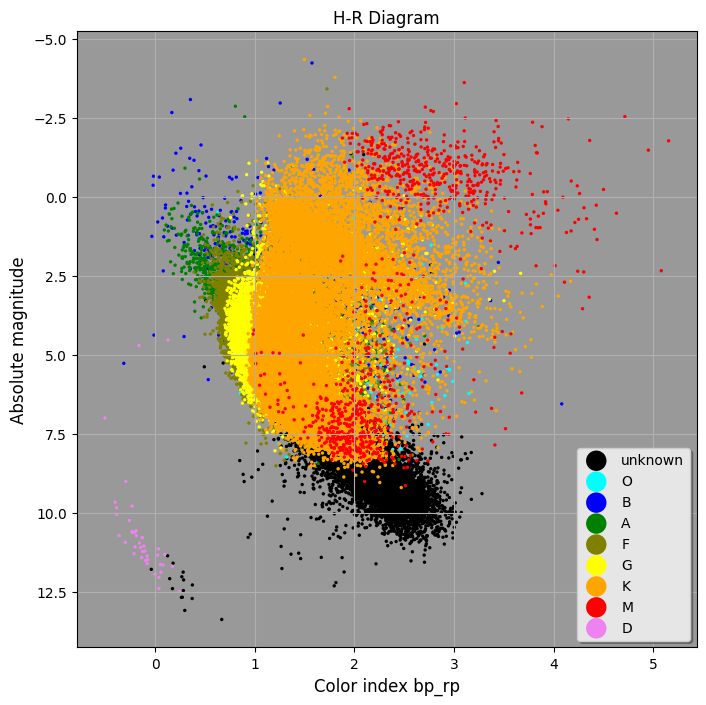

In [3]:
df_GAIA = queryStarsFromGAIA()
df_GAIA = prepareDataSet(df_GAIA)
displayHR(df_GAIA, 'bp_rp')

# Hipparcos Catalog

INFO: Query finished. [astroquery.utils.tap.core]


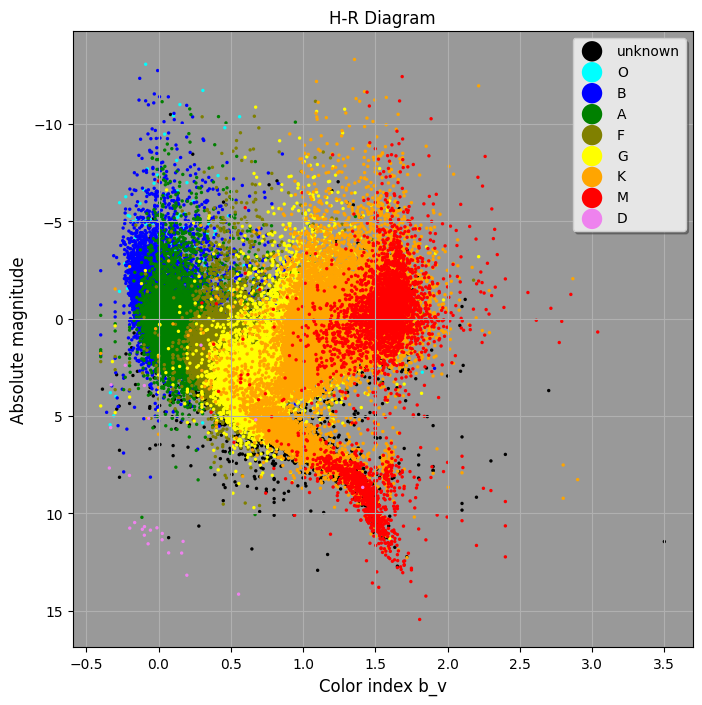

In [4]:
df_hipparcos = queryStarsFromHipparcos()
df_hipparcos = prepareDataSet(df_hipparcos)
displayHR(df_hipparcos, 'b_v')

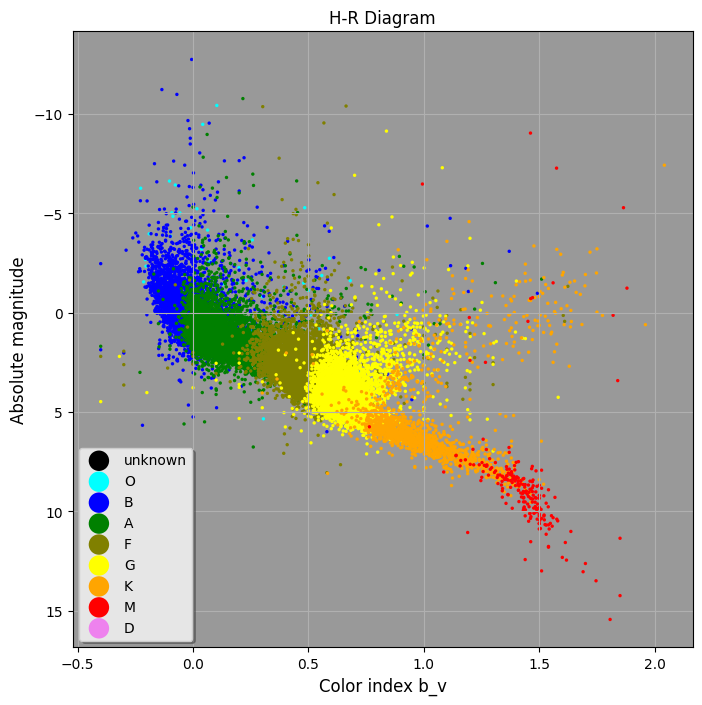

In [5]:
# Filter to Main Sequence only
f = lambda s: ('V' in s) and ('VI' not in s) and ('IV' not in s)
idx  = df_hipparcos['spectral_type'].apply(f)
df_hipparcos_main_seq = df_hipparcos[idx]
displayHR(df_hipparcos_main_seq, 'b_v')